In [18]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [19]:
#alexnet,vgg,resnet used for image classification
#faster rcnn for object detection
if (torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)

cpu


(866, 1300, 3)


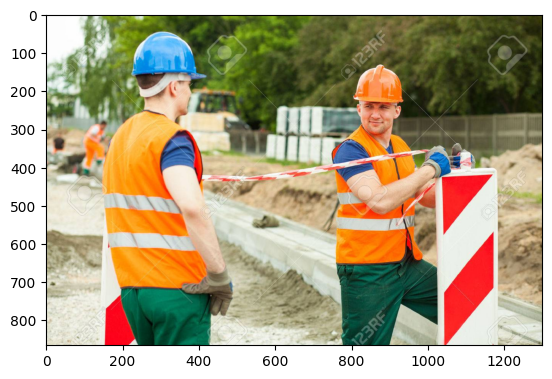

In [20]:
#reading image and showing in graph format through matplotlib
img0  = cv2.imread('sample3.jpg')
img0 = cv2.cvtColor(img0,cv2.COLOR_BGR2RGB)
print(img0.shape)
plt.imshow(img0)
plt.show()

In [21]:
#Object info: a set of bounding boxes(ymin,xmin,ymax,xmax) and their labels
bbox0 = np.array([[50,200,150,370],[100,800,250,950]])
labels = np.array([1,1]) #write 1 on label to detect helmet otherwise 0 for background, if there are more images can label 1,2,3,..

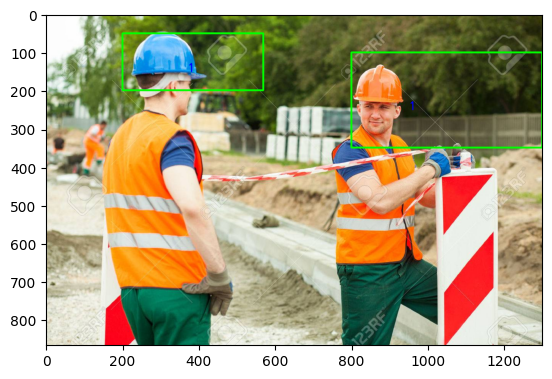

In [22]:
#display bounding boxes and labels
img0_clone = np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone,(bbox0[i][1],bbox0[i][0],bbox0[i][3],bbox0[i][2]), color=(0,255,0), thickness=4)
    cv2.putText(img0_clone, str(int(labels[i])),(bbox0[i][3],bbox0[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), thickness=2)
plt.imshow(img0_clone)
plt.show()

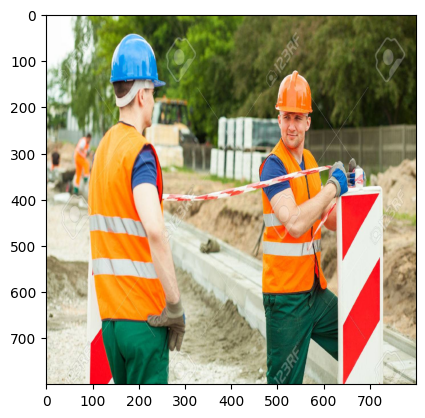

In [23]:
img = cv2.resize(img0, dsize=(800,800), interpolation = cv2.INTER_CUBIC) #faster rcnn always takes input image of size 800x800 so resize accordingly
plt.imshow(img)
plt.show()

In [24]:
#change the bounding box coordinates to now fit the 800x800 image also
Wratio= 800/img0.shape[1]
Hratio = 800/img0.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
bbox = []
for box in bbox0:
    box = [int(a*b) for a,b in zip(box,ratioLst)]
    bbox.append(box)
bbox = np.array(bbox)
print(bbox)

[[ 46 123 138 227]
 [ 92 492 230 584]]


In [25]:
#use VGG16 to extract features from input images(size of 800x800x3)
#output image will be (50x50x512) when you pass this size input into vgg16 model
#list all the layers of VGG16
model = torchvision.models.vgg16(pretrained=True).to(device)
fe = list(model.features)
print(len(fe))

31


In [26]:
#collect all layers with output feature map size(W,H) < 50
dummy = torch.zeros((1, 3, 800,800)).float() #test image array[1,3,800,800]
print(dummy.shape)


req_features = []
k = dummy.clone().to(device)
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16:
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features))
print(out_channels)

#512 is the output after our image is finally passed through layer 30 of VGG16
#after VGG16, our image goes from 800x800x3 to 50x50x512 and thus, after passing through VGG16, we can get convolutions that allow reduction in width and height, but increase the depth
#this is called subsampling in computer vision

torch.Size([1, 3, 800, 800])
30
512


In [27]:
#convert this list into a Sequential module
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

In [28]:
#input image feature extractor
transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img).to(device)
imgTensor = imgTensor.unsqueeze(0)
out_map = faster_rcnn_fe_extractor(imgTensor)
print(out_map.size())

torch.Size([1, 512, 50, 50])


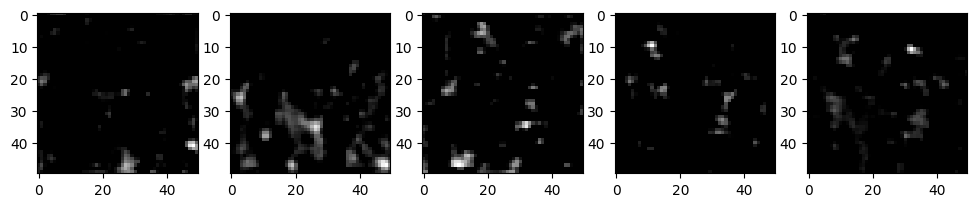

In [29]:
#initially, just visualize the first 5 channels of the 50x50x512 feature maps
#next, we just pass this feature maps into the classifier to create the bounding boxes and labels
#however, before passing it, we need to train our neural network so it can find exactly what bounding boxes go in which regions on the feature map
imgArray = out_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12,4))
figNo = 1
for i in range(5):
    fig.add_subplot(1,5,figNo)
    plt.imshow(imgArray[i], cmap='gray')
    figNo += 1
plt.show()

In [30]:
#image classification is simple because we only label the image without using bounding boxes but here we want to train our NN to detect the objects and create their bounding boxes so we need to fit our NN with the bounding box information
#now we want to generate 22,500 anchor boxes on each input image
#50x50=2500 anchors, each anchor generates 9 anchor boxes so total=50x50x9=22,500
#x,y intervals to generate anchor box center
fe_size = (800//16)
ctr_x = np.arange(16, (fe_size+1)*16, 16)
ctr_y = np.arange(16, (fe_size+1)*16, 16)
print(len(ctr_x),ctr_x)

50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [31]:
#coordinates of the 2500 center points to generate anchor boxes
index = 0
ctr = np.zeros((2500, 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index+=1
print(ctr.shape)

(2500, 2)


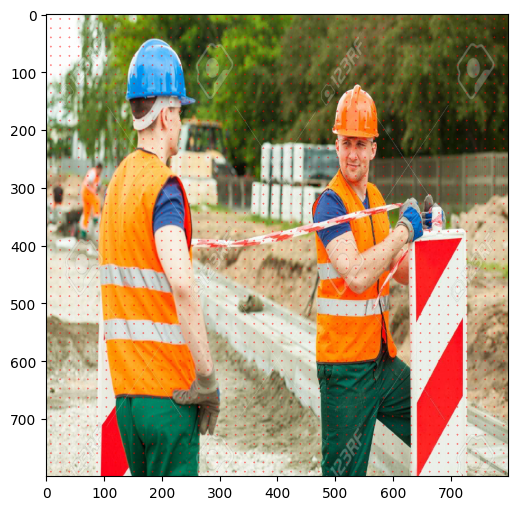

In [32]:
#display the 2500 anchors
img_clone = np.copy(img)
plt.figure(figsize=(9,6))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone, (int(ctr[i][0]),int(ctr[i][1])), radius=1, color=(255,0,0), thickness=1)
plt.imshow(img_clone)
plt.show()

In [33]:
#for each of the 2500 anchors, generate 9 anchor boxes
#2500*9=22500 anchor boxes
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16
anchor_boxes = np.zeros( ((fe_size * fe_size * 9), 4))
index = 0
for c in ctr:
    ctr_y,ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j]*np.sqrt(ratios[i])
            w = sub_sample * scales[j]*np.sqrt(1./ratios[i])
            anchor_boxes[index, 0] = ctr_y - h/2.
            anchor_boxes[index, 1] = ctr_x - w/2.
            anchor_boxes[index, 2] = ctr_y + h/2.
            anchor_boxes[index, 3] = ctr_x + w/2.
            index += 1
print(anchor_boxes.shape)

(22500, 4)


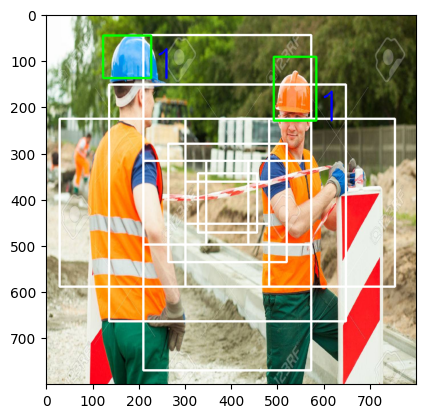

In [34]:
#display the 9 anchor boxes of anchor and the ground truth box
img_clone = np.copy(img)
for i in range(11025, 11034): #9*1225=11025
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2])
    cv2.rectangle(img_clone, (x0,y0), (x1,y1), color=(255,255,2550), thickness=3)

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3],bbox[i][2]), color = (0,255,0), thickness=3)
    cv2.putText(img_clone, str(int(labels[i])),(bbox[i][3],bbox[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255), thickness=3)

plt.imshow(img_clone)
plt.show()

In [35]:
#ignore cross-boundary anchor boxes
#valid anchor boxes with (y1, x1)>0 and (y2,x2)<=800
index_inside = np.where(
    (anchor_boxes[:,0] >= 0) &
    (anchor_boxes[:,1] >= 0) &
    (anchor_boxes[:,2] <= 800) &
    (anchor_boxes[:,3] <= 800)
    )[0]
print(index_inside.shape)

valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


In [36]:
#a valid anchor box is one whose boundaries fits within the 800x800 image
#our true answer would be the green boxes which is what we actually want to predict
#thus iou in this case is the intersection of a valid box and the true box divided by union(area of both boxes)
#high overlapping means high iou and low overlapping means low iou
# - Find the max of x1 and y1 in both the boxes (xn1, yn1)
# - Find the min of x2 and y2 in both the boxes (xn2, yn2)
# - Now both the boxes are intersecting only
#  if (xn1 < xn2) and (yn2 < yn1)
#       - iou_area will be (xn2 - xn1) * (yn2 - yn1)
#  else
#       - iou_area will be 0
# - similarly calculate area for anchor box and ground truth object
# - iou = iou_area/(anchor_box_area + ground_truth_area - iou_area)

ious = np.empty((len(valid_anchor_boxes),2), dtype=np.float32)
ious.fill(0)
print(bbox)
for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2 - yb1) * (xb2 - xb1)
        
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = max([xb2, xa2])
        inter_y2 = max([yb2, ya2])

        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else:
            iou = 0.
    ious[num1,num2] = iou
print(ious.shape)
print(np.isnan(ious).any())

[[ 46 123 138 227]
 [ 92 492 230 584]]
(8940, 2)
False


In [37]:
# if ious.size == 0 or np.isnan(ious).all():
#     # Handle the case when ious is empty or contains NaN values
#     # You can set a default value or raise an error
#     gt_argmax_ious = -1  # Example: Set to -1 as a placeholder
# else:
#     # Compute the argmax of ious
#     gt_argmax_ious = ious.argmax(axis=0)

# print(gt_argmax_ious)

#what anchor box has max iou with the ground truth bbox
#that means what is the anchor box which has max overlapping with the original box

gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

# gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
# print(gt_max_ious)

# gt_argmax_ious = np.where(ious == gt_max_ious)[0]
# print(gt_argmax_ious)

[   0 7196]


In [38]:
gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

# gt_argmax_ious = np.where(ious == gt_max_ious)[0]
# print(gt_argmax_ious)

[0.       6.093839]


In [39]:
gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[   0    1    2 ... 8937 8938 8939]


In [40]:
#what ground truth bbox is associated with each anchor box
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)
max_ious = ious[np.arange(len(index_inside)),argmax_ious]
print(max_ious)

(8940,)
[1 1 1 ... 1 1 1]
[0.77490234 0.77490234 0.77490234 ... 1.2904851  1.2904851  1.2904851 ]


In [41]:
#out of 22,500 anchor boxes, we are considering 8940 VALID anchor boxes that we pass for training in mini-batches of size = 256
#now if there is a high iou of a valid anchor box with ground box, give it a 1(object) else give it a 0(bg)
#else give it a -1 if we want to ignore the box using training
label = np.empty((len(index_inside), ), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [42]:
#assign 0(background) to an anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes(very less overlapping)
#similarly if IoU ratio is greater than 0.7 for all truth boxes, assign 1(object) to an achor
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3
label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

In [43]:
#initially,only consider 256 out of 8940 anchor boxes for the mini-batch training and ignore the rest(-1)
n_sample = 256
pos_ratio = 0.5
n_pos = int(pos_ratio * n_sample)
n_neg = int(n_sample * np.sum(label == 1))

pos_index = np.where(label == 1)[0]
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    label[disable_index] = -1

n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]
if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index)-n_neg), replace=False)
    label[disable_index] = -1


In [44]:
#for each valid anchor box, find the ground truth object which has max_iou
#Inorder to find t_{x}, t_{y}, t_{w}, t_{h}, we need to convert the y1, x1, y2, x2 format of valid anchor boxes and associated ground truth boxes with max iou to ctr_y, ctr_x , h, w format.
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox)

#valid anchor boxes h,w,cx,cy
height = valid_anchor_boxes[:,2] - valid_anchor_boxes[:,0]
width = valid_anchor_boxes[:,3] - valid_anchor_boxes[:,1]
ctr_y = valid_anchor_boxes[:,0] + 0.5*height
ctr_x = valid_anchor_boxes[:,1] + 0.5*width

#valid anchor box, max iou bbox h,w,cx,cy
base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5*base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5*base_width

#valid anchor boxes loc = (y-ya/ha), (x-xa/wa), log(h/ha), log(w/wa)
#Use the above formulas to find the loc
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(height, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_y) / width
dh = np.log(base_height/height)
dw = np.log(base_width/width)
anchor_locs = np.vstack((dy,dx,dh,dw)).transpose()
print(anchor_locs)

[[ 92 492 230 584]
 [ 92 492 230 584]
 [ 92 492 230 584]
 ...
 [ 92 492 230 584]
 [ 92 492 230 584]
 [ 92 492 230 584]]
[[ 0.31488349  2.39753393 -0.27135017 -0.67681528]
 [ 0.22649514  2.30914558 -0.27135017 -0.67681528]
 [ 0.13810679  2.22075723 -0.27135017 -0.67681528]
 ...
 [-2.77870868 -0.69605824 -0.27135017 -0.67681528]
 [-2.86709703 -0.78444659 -0.27135017 -0.67681528]
 [-2.95548537 -0.87283493 -0.27135017 -0.67681528]]


In [45]:
#Now we got anchor_locs and label associated with each and every valid anchor boxes
#Lets map them to the original anchors using the inside_index variable. Fill the unvalid anchor boxes labels with -1 (ignore) and locations with 0.

#final labels
anchor_labels = np.empty((len(anchor_boxes),),dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape) #final matrix 1 for labels

#final locations
anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside,:] = anchor_locs
print(anchor_locations.shape) #final matrix 2 for locations

#These matrices are used as targets to the RPN network

(22500,)
(22500, 4)


In [46]:
#now we want to train our region proposal network to recognize 22,500 ROI's(regions of interest)
#we have n x 5 ground truth boxes, in our case we initially gave 2 bounding boxes for identification of the helmets so n=2 and 5 because each bounding box has 4 coordinates + 1 label
#we must send the feature maps to the RPN to generate 22500 region proposals

#To generate region proposals, we slide a small network over the convolutional feature map output that we obtained in the feature extraction module. This small network takes as input an n x n spatial window of the input convolutional feature map. Each sliding window is mapped to a lower-dimensional feature [512 features]. This feature is fed into two sibling fully connected layers: A box regrression layer and a box classification layer
#The sliding window architecture is effectively realized using an n × n convolutional layer, followed by two 1 × 1 convolutional layers for box regression and box classification.
in_channels = 512 # depends on the output feature map. in vgg 16 it is equal to 512
mid_channels = 512
n_anchor = 9 # Number of anchors at each location

#must initalize layers with zero mean and 0.01 standard deviation for weights and zeroes for base
# conv sliding layer
conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

# regression layer
# It predict adjustments for the bounding box of the proposed region.The “reg” FC layer returns a 4-D vector that defines the bounding box of the region proposal.
reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

# classification layer
#The “cls” FC layer is a binary classifier that assigns an objectness score to each region proposal.
#The “cls” FC layer produces two outputs: one for classifying the region as background and another for classifying the region as an object. The objectness score assigned to each anchor helps generate the classification label.
cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0).to(device) # I will be going to use softmax here. you can equally use sigmoid if u replace 2 with 1.
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [47]:
#Now the outputs we got in the feature extraction state should be sent to our network(rpn) to predict locations of objects with repect to the anchor and the objectness score assoiciated with it.
x = conv1(out_map.to(device)) #out_map = faster_rcnn_fe_extractor(imgTensor)
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [48]:
#Lets reformat these a bit and make it align with our anchor targets we designed previously. We will also find the objectness scores for each anchor box, as this is used to for proposal layer which we will discuss in the next section
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)
#Out: torch.Size([1, 22500, 4])

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores)
#Out torch.Size([1, 50, 50, 18])

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)
#Out torch.Size([1, 22500])

pred_cls_scores  = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)
# Out torch.size([1, 22500, 2])

#pred_cls_scores and pred_anchor_locs are the outputs of the rpn network and the losses to update the weights

torch.Size([1, 22500, 4])
tensor([[[[ 0.0220,  0.0166, -0.0008,  ...,  0.0158, -0.0403,  0.0257],
          [ 0.0042,  0.0515, -0.0263,  ..., -0.0053, -0.1087,  0.0445],
          [ 0.0133,  0.0528, -0.0306,  ...,  0.0191, -0.0629,  0.0079],
          ...,
          [ 0.0144,  0.0357,  0.0353,  ...,  0.0442,  0.0204, -0.0746],
          [ 0.0193,  0.0308,  0.0289,  ...,  0.0443,  0.0239, -0.0633],
          [ 0.0034,  0.0548,  0.0124,  ...,  0.0282,  0.0002, -0.0017]],

         [[-0.0187,  0.0210,  0.0177,  ...,  0.0147,  0.0438, -0.0075],
          [ 0.0189,  0.0652,  0.0270,  ...,  0.0148, -0.0250,  0.0075],
          [ 0.0675,  0.0769,  0.0366,  ...,  0.0257, -0.0449, -0.0263],
          ...,
          [ 0.0378,  0.0575, -0.0215,  ...,  0.0754,  0.0523, -0.0595],
          [ 0.0209,  0.0603, -0.0391,  ...,  0.0474,  0.0244, -0.0320],
          [ 0.0198,  0.0457, -0.0010,  ...,  0.0188,  0.0021, -0.0002]],

         [[ 0.0018,  0.0312,  0.0406,  ..., -0.0055,  0.0301, -0.0234],
    

In [49]:
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [50]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [51]:
#for classification, we always use cross-entropy loss in faster rcnn
rpn_cls_loss = F.cross_entropy(rpn_score,gt_rpn_score.long().to(device),ignore_index=-1)
print(rpn_cls_loss)

tensor(0.6929, grad_fn=<NllLossBackward0>)


In [52]:
#for regression, we always use smooth L1 loss in faster rcnn
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

#take those bounding boxes which have positive labels
mask_loc_preds = rpn_loc[mask].view(-1,4)
mask_loc_targets = gt_rpn_loc[mask].view(-1,4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x<1).float()*0.5*x**2) + ((x >=1).float()*(x-0.5))
print(rpn_loc_loss.sum())

torch.Size([22500, 4])
torch.Size([128, 4]) torch.Size([128, 4])
tensor(316.8575, dtype=torch.float64, grad_fn=<SumBackward0>)


In [53]:
#combining both the rpn_cls_loss and rpn_reg_loss
rpn_lambda = 10.
N_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(25.4474, dtype=torch.float64, grad_fn=<AddBackward0>)


In [54]:
# For each window position, K region proposals are generated. Each proposal is defined by an anchor box, which is parameterized by scale and aspect ratio.
# Multiple anchor boxes are created by varying these parameters, resulting in different scales and aspect ratios. This creates a set of anchor boxes, usually K=9, allowing the model to consider various object sizes and shapes.
# We fix the IoU threshold for NMS at 0.7, which leaves us about 2000 proposal regions per image.
#During testing they evaluate only 300 proposals, they have tested this with various numbers and obtained this.


#we want to use NMS to reduce our regions of interest from 22500 to 2000 ROI
nms_thresh = 0.7 #non-maximum suppression
n_train_pre_nms = 12000 #no. of train pre-NMS
n_train_post_nms = 2000 #after nms, training fast rcnn using 2000 rpn proposals
n_test_pre_nms = 6000
n_test_post_nms = 300 #during testing, we evaluate 300 proposals
min_size = 16

In [55]:
#in order to generate region of interest proposals to the network, we need to do the reverse operations
#we need to convert the loc predictions from the rpn network to bbox[y1,x1,y2,x2] format
#clip the predicted boxes to the image but remove the predicted boxes with either height or width<threshold(min_size)
#sort all (proposal,score) pairs by score from highest to lowest
#Take top pre_nms_topN (e.g. 12000 while training and 300 while testing) and apply nms threshold > 0.7
#Take top pos_nms_topN (e.g. 2000 while training and 300 while testing)

In [56]:
#the labelled 22500 anchor boxes
#Convert anchors format from [y1, x1, y2, x2] to [ctr_x, ctr_y, h, w]
anc_height = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_width = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_ctr_y = anchor_boxes[:, 0] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 1] + 0.5 * anc_width
print(anc_ctr_x.shape)

(22500,)


In [57]:
#The 22500 anchor boxes location and labels predicted by RPN(convert to numpy)
#Convert predictions locs using above formulas. before that convert the pred_anchor_locs and objectness_score to numpy array
#format = (dy, dx, dh, dw)
pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()
dy = pred_anchor_locs_numpy[:, 0::4] #anchor box dy
dx = pred_anchor_locs_numpy[:, 1::4] #dx
dh = pred_anchor_locs_numpy[:, 2::4] #dh
dw = pred_anchor_locs_numpy[:, 3::4] #dw
print(dy.shape)


#ctr_y = dy predicted by RPN * anchor_h + anchor_cy
#ctr_x is similiar
ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500, 1)
(22500, 1)


In [58]:
#convert [ctr_x, ctr_y, h, w] to [y1, x1, y2, x2] format
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_y - 0.5 * h
roi[:, 1::4] = ctr_x - 0.5 * w
roi[:, 2::4] = ctr_y + 0.5 * h
roi[:, 3::4] = ctr_x + 0.5 * w
print(roi.shape)
#Out:
# [[ -36.897102,  -80.29519 ,   54.09939 ,  100.40507 ],
#  [ -83.12463 , -165.74298 ,   98.67854 ,  188.6116  ],
#  [-170.7821  , -378.22214 ,  196.20844 ,  349.81198 ],
#  ...,
#  [ 696.17816 ,  747.13306 ,  883.4582  ,  836.77747 ],
#  [ 621.42114 ,  703.0614  ,  973.04626 ,  885.31226 ],
#  [ 432.86267 ,  622.48926 , 1146.7059  ,  982.9209  ]]

(22500, 4)


In [59]:
#clip the predicted boxes to the image
img_size = (800, 800) #Image size
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])
print(roi.shape, np.max(roi), np.min(roi))
#Out:
# [[  0.     ,   0.     ,  54.09939, 100.40507],
#  [  0.     ,   0.     ,  98.67854, 188.6116 ],
#  [  0.     ,   0.     , 196.20844, 349.81198],
#  ...,
#  [696.17816, 747.13306, 800.     , 800.     ],
#  [621.42114, 703.0614 , 800.     , 800.     ],
#  [432.86267, 622.48926, 800.     , 800.     ]]

(22500, 4) 800.0 0.0


In [60]:
#Remove predicted boxes with either height or width < threshold.
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)
#Out:
##(22500, ) all the boxes have minimum size of 16

(22500,) (22500, 4) (22500,)


In [61]:
#Sort all (proposal, score) pairs by score from highest to lowest.
order = score.ravel().argsort()[::-1]
print(order)
print(order.shape)

#Out:
#[ 889,  929, 1316, ...,  462,  454,    4]

[5499 5040 5490 ... 5497 4602 4611]
(22500,)


In [62]:
#Take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape)
print(roi.shape)
print(roi)
#Out
# (12000, 4)
# [[607.93866,   0.     , 800.     , 113.38187],
#  [  0.     ,   0.     , 235.29704, 369.64795],
#  [572.177  ,   0.     , 800.     , 373.0086 ],
#  ...,
#  [250.07968, 186.61633, 434.6356 , 276.70615],
#  [490.07974, 154.6163 , 674.6356 , 244.70615],
#  [266.07968, 602.61633, 450.6356 , 692.7062 ]]

(12000,)
(12000, 4)
[[152.63316962 136.73190506 227.71334167 323.2430361 ]
 [151.85751965 149.18888263 200.56180278 316.22498133]
 [142.88221406 146.77871301 204.08079759 349.74390897]
 ...
 [101.91488457 682.662992   233.22135735 797.09677649]
 [437.37496273   0.         800.         351.61844581]
 [  0.         343.4148823  429.71132703 694.71726164]]


In [63]:
# The sudo code for NMS works in the following way

# - Take all the roi boxes [roi_array]
# - Find the areas of all the boxes [roi_area]
# - Take the indexes of order the probability score in descending order [order_array]
# keep = []
# while order_array.size > 0:
# - take the first element in order_array and append that to keep  
# - Find the area with all other boxes
# - Find the index of all the boxes which have high overlap with this box
# - Remove them from order array
# - Iterate this till we get the order_size to zero (while loop)
# - Ouput the keep variable which tells what indexes to consider.

In [64]:
#Take top pos_nms_topN (e.g. 2000 while training and 300 while testing)

#take all the roi boxes[roi_array]
y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]
#find the areas of all the boxes [roi_area]
areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [65]:
#take the indexes of order the probability score in descending order
order = order.argsort()[::-1]
keep = []
while (order.size > 0):
    i = order[0] #take the last element in order and append to keep
    keep.append(i)
    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]
keep = keep[:n_train_post_nms] # while training/testing , use accordingly
roi = roi[keep] # the final region proposals
print(len(keep),roi.shape)

2000 (2000, 4)


In [66]:
n_sample = 128 #number of samples from roi
pos_ratio = 0.25 #number of positive examples out of the n_samples
pos_iou_thresh = 0.5 #min iou of region proposal with any groundtruth object to consider it as positive label
neg_iou_thresh_hi = 0.5 #iou 0-0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [67]:
#find the iou of each ground truth object with the region proposals
#after using nms to create 2000 roi from original 22500 roi proposed by rpn, we sample only 128 roi samples based on their iou with the original truth boxes
ious = np.empty((len(roi), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(roi):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area + box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)
#Out: 
#[1535, 2]

(2000, 2)


In [68]:
#find out which ground truth has high IoU for each region proposal, also find the maximum IoU
gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)
print(gt_assignment)
print(max_iou)
#Out:
# [0, 0, 0 ... 1, 1, 0]
# [0.016, 0., 0. ... 0.08034518, 0.10739268, 0.]

#Assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)
#Out:
#[6, 6, 6, ..., 8, 8, 6]

[0 0 0 ... 0 0 0]
[0.         0.         0.         ... 0.         0.         0.01749417]
[1 1 1 ... 1 1 1]


In [69]:
#select the foreground rois as per the pos_io_thresh and
#n_sample x pos_ratio (128 x 0.25 = 32) foreground samples
pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(
        pos_index, size=pos_roi_per_this_image, replace=False)
print(pos_roi_per_this_image)
print(pos_index)
#Out
# 18
# [ 257  296  317 1075 1077 1169 1213 1258 1322 1325 1351 1378 1380 1425
#  1472 1482 1489 1495]

neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                             (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image,
                                 neg_index.size))
if  neg_index.size > 0 :
    neg_index = np.random.choice(
        neg_index, size=neg_roi_per_this_image, replace=False)
print(neg_roi_per_this_image)
print(neg_index)
#Out:
#110
# [  79  688  160  ...  376  712 1235  148 1001]

3
[794 843 845]
125
[1688  707 1020 1620  252 1849  883 1315 1758 1983 1120 1644 1257 1061
  556  687  644 1127 1045  716 1565 1434  681 1391 1599  902  227 1595
 1641 1233  100  300  540 1740  653 1744  239 1598 1425  789  484  187
 1407  565 1794 1296  953  370 1393  515  690  832 1256 1371 1703  382
 1670 1463 1060 1582 1450 1592 1309  323  978 1895   48  178 1373 1011
 1643   96  536  802 1915   70  570 1207 1237 1880 1493  398   60  965
 1906   83  692  722 1057   75 1559 1325 1249 1888 1891  668 1637 1176
 1824 1374 1657 1576  503 1605  287  857 1039  283  454 1662 1284 1841
 1695 1909 1746 1797 1302  337 1899 1506 1082  427  520  531 1485]


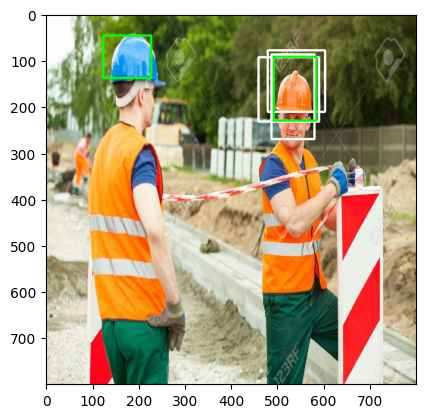

In [70]:
#display ROI samples with positive
img_clone = np.copy(img)
for i in range(pos_roi_per_this_image):
    y0, x0, y1, x1 = roi[pos_index[i]].astype(int)
    cv2.rectangle(img_clone, (x0,y0),(x1,y1), color=(255,255,2550), thickness=3)

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0,255,0), thickness=3) #draw rectangle

plt.imshow(img_clone)
plt.show()

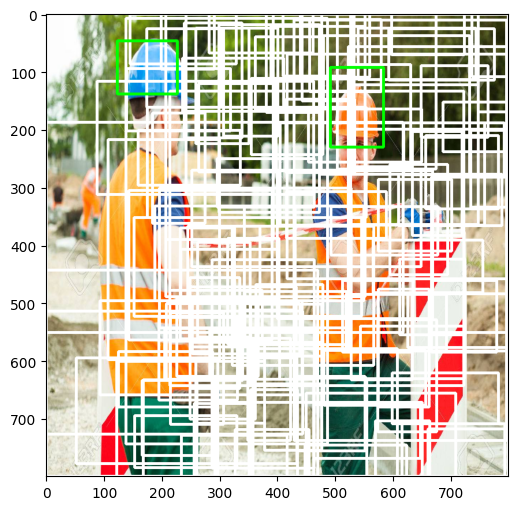

In [71]:
#display ROI samples with negative
img_clone = np.copy(img)
plt.figure(figsize=(9,6))
for i in range(neg_roi_per_this_image):
    y0, x0, y1, x1 = roi[neg_index[i]].astype(int)
    cv2.rectangle(img_clone, (x0,y0),(x1,y1), color=(255,255,2550), thickness=3)

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0,255,0), thickness=3) #draw rectangle

plt.imshow(img_clone)
plt.show()

In [72]:
#now we gather positive samples index and negative samples index
#their respective labels and region proposals

keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0  # negative labels --> 0
sample_roi = roi[keep_index]
print(sample_roi.shape)
#Out:
#(128, 4)

bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)
#Out
#(128, 4)
height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 1]
ctr_y = sample_roi[:, 0] + 0.5 * height
ctr_x = sample_roi[:, 1] + 0.5 * width
base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_y = bbox_for_sampled_roi[:, 0] + 0.5 * base_height
base_ctr_x = bbox_for_sampled_roi[:, 1] + 0.5 * base_width

(128, 4)
(128, 4)


In [73]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height,eps)
width = np.maximum(width,eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

gt_roi_locs = np.vstack((dy,dx,dh,dw)).transpose()
print(gt_roi_locs.shape)

(128, 4)


In [74]:
#now we must pass the feature maps of the 128 ROI samples
#take each 128 ROI one by one and scale it down to sample into a feature map(scaled from 800x800x3 image to fit into a 50x50x512 feature map)
rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)
#Out:
#torch.Size([128, 4]) torch.Size([128])

torch.Size([128, 4]) torch.Size([128])


In [75]:
indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)
#Out:
#torch.Size([128, 5])

torch.Size([128, 5])


In [76]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])
output = [] 
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # Subsampling ratio
rois = rois.long()
num_rois = rois.size(0)
for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = adaptive_max_pool(im)
    output.append(tmp[0])
output = torch.cat(output, 0)
print(output.size())
#Out:
# torch.Size([128, 512, 7, 7])
# Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1)
print(k.shape)

#Out:
# torch.Size([128, 25088])

torch.Size([128, 512, 7, 7])
torch.Size([128, 25088])


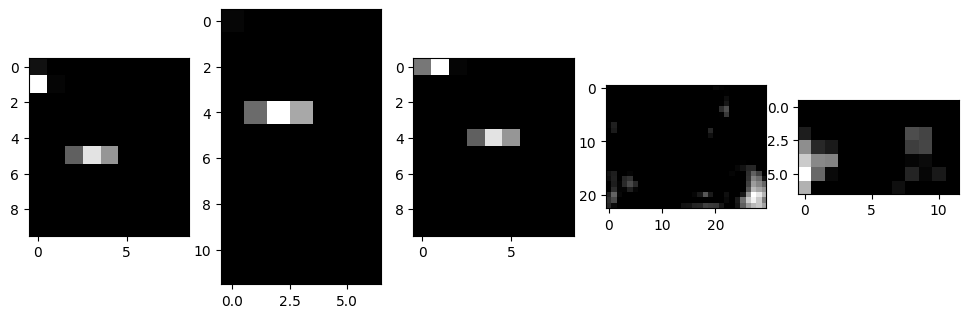

In [77]:
#visualize the first 5 ROI's feature map (for each feature map. only show the 1st channel of d=512)
#bounding boxes are of diff sizes so feature maps are also of diff sizes but if we want to feed these into any network, the input size should be the same
#thus, we use a technique called ROI pooling which uses max pooling to make every feature map the same size
#in this eg, we are making them 7x7
#max pooling reduces the feature maps to the same size


#original feature maps
fig = plt.figure(figsize=(12,4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1,5,figNo)
    plt.imshow(tmp, cmap='gray')
    figNo+=1
plt.show()

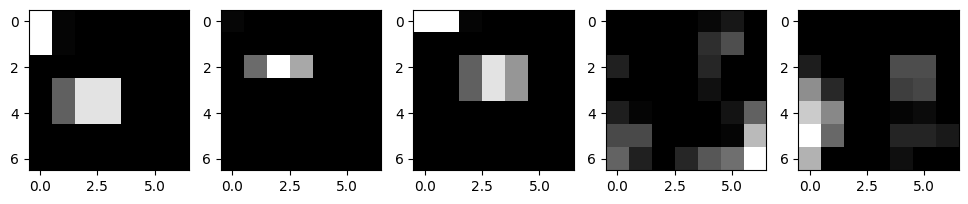

In [78]:
#pooled feature maps
fig = plt.figure(figsize=(12,4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = adaptive_max_pool(im)[0]
    tmp = tmp[0][0].detach().cpu().numpy()
    fig.add_subplot(1,5,figNo)
    plt.imshow(tmp, cmap='gray')
    figNo+=1
plt.show()

In [79]:
#reshape the tensor so that we can pass it through the feed forward layer

k = output.view(output.size(0),-1)
print(k.shape) #25088 = 7*7*512

torch.Size([128, 25088])


In [80]:
#now that we have all feature maps of 128 ROI samples of same size(7x7x512)
#we simply send it to the detection network

#uses 3 neural networks; first is traditional CNN (VGG16)
#second is region proposal network (RPN)
#third is detection network

roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096),nn.Linear(4096, 4096)])
cls_loc = nn.Linear(4096, 2 * 4).to(device) # (right now 1 class + 1 background so 2. Each will have 4 co-ordinates)
#if using voc then do 21*4 as (VOC 20 classes + 1 background. Each will have 4 co-ordinates)
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()
score = nn.Linear(4096, 2).to(device) # (1 class + 1 background so 2) 
# for VOC we do (VOC 20 classes + 1 background)

In [81]:
k = roi_head_classifier(k.to(device))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)
print(roi_cls_loc.shape, roi_cls_score.shape)
#Out:
# torch.Size([128, 84]), torch.Size([128, 21]) if we use 21 with VOC 20 classes for eg but we used 2 here

torch.Size([128, 8]) torch.Size([128, 2])


In [82]:
#predicted
print(roi_cls_loc.shape, roi_cls_score.shape)

#actual
print(gt_roi_locs.shape, gt_roi_labels.shape)

torch.Size([128, 8]) torch.Size([128, 2])
(128, 4) (128,)


In [83]:
gt_roi_labels

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [84]:
#converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()

#classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)
print(roi_cls_loss.shape)

torch.Size([])


In [85]:
#regression loss
n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

#for regression we use smooth L1 loss as defined in the Fast RCNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

#take those bounding boxes which have positive labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_preds.shape)

x = torch.abs(mask_loc_targets - mask_loc_preds)
roi_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
print(roi_loc_loss.sum())



torch.Size([128, 2, 4])
torch.Size([128, 4])
torch.Size([128, 4])
torch.Size([3, 4]) torch.Size([3, 4])
tensor(0.8262, dtype=torch.float64, grad_fn=<SumBackward0>)


In [86]:
roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
print(roi_loss)

tensor([[0.7752, 1.4440, 0.9393, 1.2610],
        [0.7854, 1.2633, 2.4168, 1.2624],
        [0.9038, 2.3629, 2.6571, 1.3828]], dtype=torch.float64,
       grad_fn=<AddBackward0>)


In [87]:
total_loss = rpn_loss + roi_loss
print(total_loss)

tensor([[26.2226, 26.8914, 26.3867, 26.7084],
        [26.2328, 26.7107, 27.8642, 26.7098],
        [26.3512, 27.8103, 28.1045, 26.8302]], dtype=torch.float64,
       grad_fn=<AddBackward0>)
